In [1]:
import numpy as np
import illustris_python as il
import pandas as pd
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

import caesar

In [8]:
TNG3snappath   = "/Volumes/Seagate/TNG300-3/output"
TNG3grouppath   = "/Volumes/Seagate/TNG300-1/output"
TNG3num=99

TNG1snappath   = "/Volumes/Seagate/TNG100-3/output"
TNG1grouppath   = "/Volumes/Seagate/TNG100-1/output"
TNG1num=99

ILLsnappath    = "/Volumes/Seagate/Illustris-3/output"
ILLgrouppath    = "/Volumes/Seagate/Illustris-1/output"
ILLnum=135

SIMBAsnappath  = "/Volumes/Seagate/Simba-Flag/output/snapdir_001/snap_m100n1024_151.hdf5"
SIMBAgrouppath  = "/Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5"

In [99]:
def Params(path,num):
    #Group parameters
    if "Simba" in path:
        subhalos=caesar.load(path)
        subhalo_pos=np.array([i.pos.to('Mpc/h') for i in subhalos.galaxies],dtype=np.float32) # Mpc/h
        subhalo_mass=np.array([i.masses['total'].to('Msun/h') for i in subhalos.galaxies],dtype=np.float32) # Msun
        boxsize=np.float64(subhalos.simulation.boxsize.to('Mpc/h')) # Mpc/h
    else:
        fields = ["SubhaloPos","SubhaloMass"]
        subhalos = il.groupcat.loadSubhalos(path,num,fields=fields)
        subhalo_pos=subhalos["SubhaloPos"]/1000   # Mpc/h
        subhalo_mass=subhalos["SubhaloMass"]*1e10 # Msun/h
        header = il.groupcat.loadHeader(path,num)
        boxsize = header["BoxSize"]/1000 # Mpc/h
        
    #Group average density
    volume = boxsize**3              # (Mpc/h)^3
    mass_tot = np.sum(subhalo_mass)  # Msun/h
    rho_avg = mass_tot/volume        # Msun/h / (Mpc/h)^3
    print(rho_avg)
    
    return subhalo_pos,subhalo_mass,rho_avg,boxsize

In [74]:
def Over_desnity(subhalo_pos,subhalo_mass,rho_avg,center):
    rho_over=[]
    for i in range(np.shape(center)[0]):
        #Select subhalos inside sphere
        dist = np.linalg.norm(subhalo_pos - center[i], axis=1)
        mask = dist <= 8.0
        m_total = subhalo_mass[mask].sum()

        #Compute density and over desnity
        volume = (4/3) * np.pi * 8**3       # (Mpc/h)^3
        rho = m_total / volume              # Msun/h / (Mpc/h)^3
        rho_sphere=(rho-rho_avg)/rho_avg    # No Units
        
        rho_over.append(rho_sphere)
    
    return np.array(rho_over)

In [75]:
def Spheres(boxsize):
    #Number of spheres that fit along one axis
    N = int(boxsize//16)
    coords = np.linspace(8, boxsize - 8, N)

    #Create 3d grid
    xv, yv, zv = np.meshgrid(coords, coords, coords, indexing="ij")
    centers = np.vstack([xv.ravel(), yv.ravel(), zv.ravel()]).T
    
    return centers

In [76]:
def Stats(path, num):
    #Subhalo parameters
    subhalo_pos,subhalo_mass,rho_avg,boxsize=Params(path,num) 

    #Sphere centers equally spaced, non overlapping, and not outside sim
    centers=Spheres(boxsize)

    #Overdesnity
    rho_over=Over_desnity(subhalo_pos,subhalo_mass,rho_avg,centers)
    
    #Statistics
    rho_mean=np.mean(rho_over)
    rho_std=np.std(rho_over)
    rho_err=rho_std/np.sqrt(int(np.shape(rho_over)[0]))
    rho_dis=f"{rho_mean:.2f}±{rho_err:.2f}"
    rms=np.sqrt(np.mean(rho_over**2))
    
    stats=[rho_mean,rho_std,rho_err,rho_dis,rms,rho_over]
    
    return stats

In [98]:
sim_array=[["SIMBA",SIMBAgrouppath,0],
          ["TNG100",TNG1grouppath,TNG1num],
          ["Illustrious",ILLgrouppath,ILLnum],
          ["TNG300",TNG3grouppath,TNG3num]] #name,path,num

name_display=[]
rho_display=[]
rms_display=[]
rho_over_display=[]
rho_mean=[]
rho_err=[]
for i in sim_array:
    name_display.append(i[0])
    temp_stats=Stats(i[1],i[2]) #0 Mean,1 Standard Devation,2 Standard Error,3 Mean+/-Error,4 Root Mean Square,5 Over density
    rho_mean.append(temp_stats[0])
    rho_err.append(temp_stats[2])
    rho_display.append(temp_stats[3])
    rms_display.append(temp_stats[4])
    rho_over_display.append(temp_stats[5])

yt : [INFO     ] 2025-08-28 16:40:06,906 Opening /Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5
yt : [INFO     ] 2025-08-28 16:40:06,948 Found 464043 halos
yt : [INFO     ] 2025-08-28 16:40:07,000 Found 55609 galaxies


436555978.1130249


Exception: Group catalog does not have requested field [GroupPos]!

In [78]:
#Rows for DF and displays
rows=[]
for i in range(4):
    rows.append({"Simulation":name_display[i], "Over Density Mean":rho_display[i], "RMS":rms_display[i]})
displaydf=pd.DataFrame(rows)
display(displaydf)

,Simulation,Over Density Mean,RMS
0,SIMBA,0.02±0.08,1.119596
1,TNG100,-0.09±0.11,0.891891
2,TNG300,0.00±0.03,1.268025
3,Illustrious,-0.08±0.10,0.843528


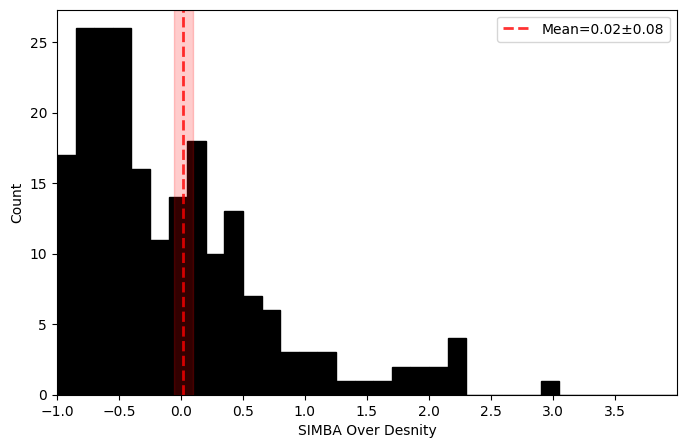

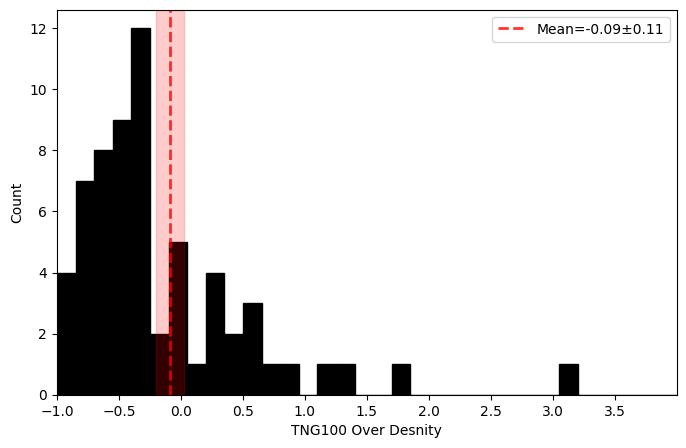

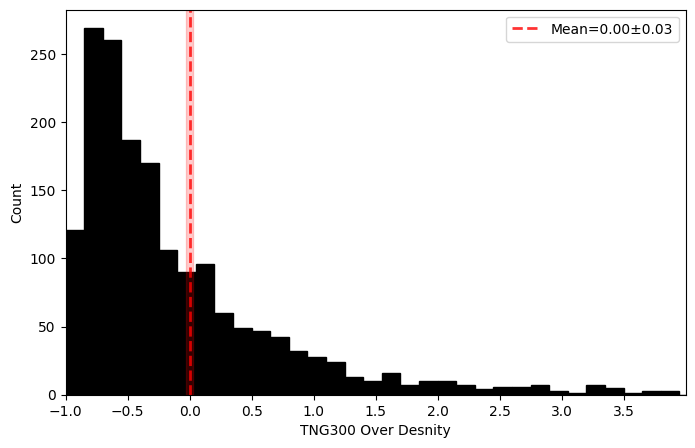

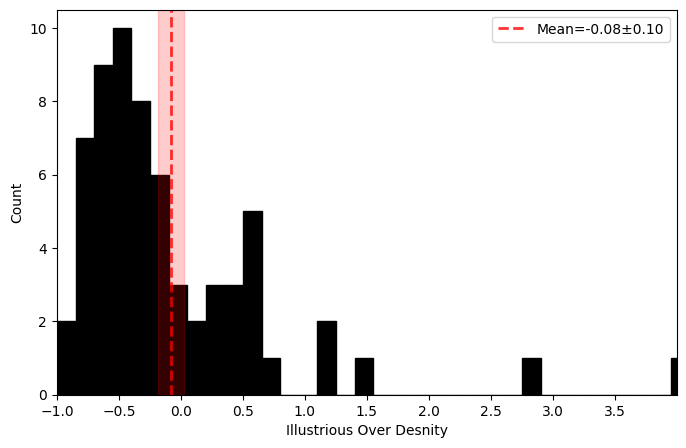

In [88]:
#Range and Bins
x_min = -1
x_max = 4

bin_width = 0.15
bins = np.arange(x_min, x_max + bin_width, bin_width)

for i in range(len(sim_array)):
    #Plot histogram
    plt.figure(figsize=(8,5))
    
    #Data
    plt.hist(rho_over_display[i], bins=bins, color="black", edgecolor='black', alpha=1)

    #Mean line
    plt.axvline(rho_mean[i], color='red', linestyle='--', linewidth=2, alpha=0.8, label="Mean="+rho_display[i])

    #Standard error shaded region
    plt.axvspan(rho_mean[i] - rho_err[i], rho_mean[i] + rho_err[i], color='red', alpha=0.2)

    #Labels and title
    plt.xlabel(sim_array[i][0]+" Over Desnity")
    plt.ylabel("Count")
    plt.xticks(np.arange(x_min, x_max, .5))
    plt.xlim(x_min, x_max)
    plt.legend()

    plt.show()